In [60]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import os
from torch.autograd import Variable

In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
def flip_labels(y, class1_noise, class2_noise):
    n = len(y)
#     y = np.array([abs(1 - y[i]) if i in random.sample(range(n), int(noise_level * n)) else y[i] for i in range(n)])
    # Flip class 1 labels from 1 to 0
    class1 = y[np.where(y == 1)]
    class1_size = len(class1)
    y[np.where(y == 1)] = np.array([abs(1 - class1[i]) if i in random.sample(range(class1_size), int(class1_noise * class1_size)) else class1[i] for i in range(class1_size)])

    # Flip class 2 labels from 0 to 1
    class2 = y[np.where(y == 0)]
    class2_size = len(class2)
    y[np.where(y == 0)] = np.array([abs(1 - class2[i]) if i in random.sample(range(class2_size), int(class2_noise * class2_size)) else class2[i] for i in range(class2_size)])

    return y

In [63]:
def generate_data(n_samples_1, n_samples_2, noise_level, test_shift=False, seed=15, display=False):
    centers = [[0.0, 0.0], [1, 1.]]
    clusters_std = [0.4, 0.4]
    X, y = make_blobs(n_samples=[n_samples_1, n_samples_2],
                      centers=centers,
                      cluster_std=clusters_std,
                      random_state = 15,
                      shuffle=False)
    if test_shift:
        # Randomly flip a percentage of test labels
        y = flip_labels(y, noise_level * 0.7, noise_level * 0.3)
        
    # Split into train, test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    
    if not test_shift:
        # Randomly flip a percentage of training labels
        y_train = flip_labels(y_train, noise_level * 0.7, noise_level * 0.3)
    
    if display:
        plt.scatter(X_train[:,0], X_train[:,1], c=['#516091' if y==1 else '#A9ECA2' for y in y_train])
#         plt.scatter(X_test[:,0], X_test[:,1], c=['#516091' if y==1 else '#A9ECA2' for y in y_test])
#         plt.savefig('0.4_percent_noise.png')
    
    y_train = y_train.reshape(-1, 1)
    X_train = torch.tensor(X_train, dtype=torch.float)
    y_train = torch.tensor(y_train, dtype=torch.float)
    
    y_test = y_test.reshape(-1, 1)
    X_test = torch.tensor(X_test, dtype=torch.float)
    y_test = torch.tensor(y_test, dtype=torch.float)
    
    return X_train, X_test, y_train, y_test

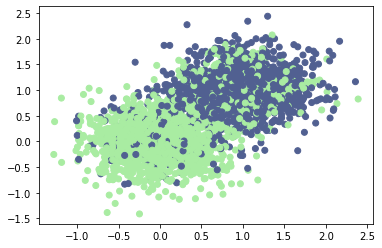

In [64]:
X_train, X_test, y_train, y_test = generate_data(2000, 2000, 0.4, test_shift=True, display=True)

In [65]:
import sys
sys.path.insert(0, '/Users/william/Documents/CMU/Research/RiskSensitiveLearning/SupervisedLearning/objectives')
import cvar, human_aligned_risk, entropic_risk, trimmed_risk, mean_variance

In [66]:
input_size = 2
output_size = 2

class LogisticRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegression, self).__init__()
        self.fc1 = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        return x
    
learning_rate = 1e-2

In [67]:
def eval_under_objective(model, X, y, objective):
    model.eval()
    with torch.no_grad():
        output = model(X)
        loss = objective(output, y.squeeze(1).type(torch.LongTensor))
    return loss.item()

In [109]:
def colorFader(c1, c2, levels=20):
    c1 = np.array(mpl.colors.to_rgb(c1))
    c2 = np.array(mpl.colors.to_rgb(c2))
    alphas = np.linspace(0, 1, levels)
    return [mpl.colors.to_hex((1 - a) * c1 + a * c2) for a in alphas]

def plot_decision_boundary(model, x_min, x_max, y_min, y_max, objective_name, fname):
    # define the x and y scale
    x1grid = np.arange(x_min, x_max, 0.1)
    x2grid = np.arange(y_min, y_max, 0.1)

    # create all of the lines and rows of the grid
    xx, yy = np.meshgrid(x1grid, x2grid)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))

    pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
    pred = pred.detach().numpy()

    # keep probabilities for class 0
    pred = pred[:, 0]
    # reshape the predictions back into a grid
    zz = pred.reshape(xx.shape)

    # plot the grid of x, y and z values as a surface
    levels = 7
    c = plt.contourf(xx, yy, zz, levels=levels, colors=colorFader('#516091', '#a9eca2', levels+2))
    # add a legend, called a color bar
    plt.colorbar(c)
    
    path = 'noisy_labels/decision_boundaries/' + objective_name + '/'
    os.makedirs(path, exist_ok=True)
    plt.savefig(path + fname + '.png')
    
    plt.close()

In [114]:
def plot_loss_distribution(losses, path, objective_name, fname):
    plt.figure(figsize=(10,6))
    
    weights = np.ones_like(losses) / len(losses)
    bins = np.linspace(0, 5, 50)
    n, bins, patches = plt.hist(x=losses, bins=bins, color='#272f4a',
                            alpha=1, weights=weights)
    
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Cross Entropy Loss')
    plt.ylabel('Percent of Samples')
    plt.xlim(0, 5)
    plt.ylim(0, 1)
    plt.xticks(np.arange(0, 5.1, 0.5))

    os.makedirs(path, exist_ok=True)
    plt.savefig(path + fname + '.png')
    
    plt.close()

In [116]:
seeds = [i for i in range(10)]
# seeds = [90]
noises = [0.2, 0.3, 0.4]
# noises = [0.4]
objectives = {
    'Expected Value': nn.CrossEntropyLoss(),
    'CVaR': cvar.CVaR(a=0.2), # We look at bottom alpha% of losses
    'Entropic Risk': entropic_risk.EntropicRisk(t=-0.5),
    'Human-Aligned Risk': human_aligned_risk.HumanAlignedRisk(a=0.6, b=0.7),
    'Inverted CVaR': cvar.CVaR(a=0.8, inverted=True), # We look at top alpha% of losses
    'Mean-Variance': mean_variance.MeanVariance(c=0.1),
    'Trimmed Risk': trimmed_risk.TrimmedRisk(a=0.2),
}
eval_objectives = {
    'Expected Value': nn.CrossEntropyLoss(),
    'CVaR': cvar.CVaR(a=0.2), # We look at bottom alpha% of losses
    'Entropic Risk': entropic_risk.EntropicRisk(t=-0.5),
    'Human-Aligned Risk': human_aligned_risk.HumanAlignedRisk(a=0.6, b=0.7),
    'Inverted CVaR': cvar.CVaR(a=0.8, inverted=True), # We look at top alpha% of losses
    'Mean-Variance': mean_variance.MeanVariance(c=0.1),
    'Trimmed Risk': trimmed_risk.TrimmedRisk(a=0.2),
}

accuracy_latex = ''
metrics = {}

for objective in objectives.keys():
    metrics[objective + '_train'] = dict()
    metrics[objective + '_test'] = dict()
    for noise in noises:
        metrics[objective + '_train']['accuracy_noise=' + str(noise)] = []
        metrics[objective + '_test']['accuracy_noise=' + str(noise)] = []
        metrics[objective + '_train']['epochs_noise=' + str(noise)] = []
        
        train_losses = []
        test_losses = []
        
        for seed in seeds:
            X_train, X_test, y_train, y_test = generate_data(2000, 2000, noise, test_shift=True, seed=seed, display=False)

            # Get objective
            criterion = objectives[objective]

            # Reset random seeds for comparaison.
            torch.manual_seed(seed)
            random.seed(seed)
            np.random.seed(seed)

            model = LogisticRegression(input_size, output_size)
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

            epochs = 0
            converged = False
            loss_buffer = []
            while not converged:
                # Train
                model.train()
                epochs += 1
                optimizer.zero_grad()

                output = model(X_train)
                loss = criterion(output, y_train.squeeze(1).type(torch.LongTensor))

                loss.backward()
                optimizer.step()
                
                loss_buffer.append(loss.item())
                # Let convergence criterion be if current risk is within the average of past 20 risks by 1e-3
                if len(loss_buffer) > 20:
                    loss_buffer.pop(0)
                    converged = abs(loss.item() - np.mean(loss_buffer)) <= 1e-3
                else:
                    converged = False

            model.eval()
            
            # Save decision boundary visualization
            boundary_fname = objective + '_noise=' + str(noise) + '_seed=' + str(seed)
            plot_decision_boundary(model, X_train[:, 0].min() - 1, X_train[:, 0].max() + 1, X_train[:, 1].min(), X_train[:, 1].max() + 1, objective, boundary_fname)

            # Save final training loss distribution under cross entropy objective
            distribution_criterion = nn.CrossEntropyLoss(reduction='none')
            train_losses.append(distribution_criterion(output, y_train.squeeze(1).type(torch.LongTensor)).detach().numpy())
            
            for eval_objective in eval_objectives.keys():
                if eval_objective + '_noise=' + str(noise) not in metrics[objective + '_train']:
                    metrics[objective + '_train'][eval_objective + '_noise=' + str(noise)] = []
                if eval_objective + '_noise=' + str(noise) not in metrics[objective + '_test']:
                    metrics[objective + '_test'][eval_objective + '_noise=' + str(noise)] = []
                # Evaluate under training data
                metrics[objective + '_train'][eval_objective + '_noise=' + str(noise)].append(eval_under_objective(model, X_train, y_train, eval_objectives[eval_objective]))
                # Evaluate under test data
                metrics[objective + '_test'][eval_objective + '_noise=' + str(noise)].append(eval_under_objective(model, X_test, y_test, eval_objectives[eval_objective]))
                        
            # Evaluate accuracies
            with torch.no_grad():
                # Final train accuracy
                output = model(X_train)
                pred = torch.argmax(F.softmax(output, dim=1), dim=1)
                overall_acc = sum(1 for p, y in zip(pred, y_train) if p == y) / len(pred)
                metrics[objective + '_train']['accuracy_noise=' + str(noise)].append(overall_acc)
                
                # Test accuracy
                output = model(X_test)
                pred = torch.argmax(F.softmax(output, dim=1), dim=1)
                overall_acc = sum(1 for p, y in zip(pred, y_test) if p == y) / len(pred)
                metrics[objective + '_test']['accuracy_noise=' + str(noise)].append(overall_acc)
                
            # Save test loss distribution under cross entorpy objective
            test_losses.append(distribution_criterion(output, y_test.squeeze(1).type(torch.LongTensor)).detach().numpy())
            
            # Record number of epochs till convergence
            metrics[objective + '_train']['epochs_noise=' + str(noise)].append(epochs)
        
        # Plot cumulative train loss distributions
        path = 'noisy_labels/loss_distributions/train/' + objective + '/'
        distribution_fname = objective + '_train_noise=' + str(noise)
        plot_loss_distribution(np.array(train_losses).flatten(), path, objective, distribution_fname)
        
        # Plot cumulative test loss distributions
        path = 'noisy_labels/loss_distributions/test/' + objective + '/'
        distribution_fname = objective + '_test_noise=' + str(noise)
        plot_loss_distribution(np.array(test_losses).flatten(), path, objective, distribution_fname)    
        
        train_accuracy = np.mean(metrics[objective + '_train']['accuracy_noise=' + str(noise)])
        test_accuracy = np.mean(metrics[objective + '_test']['accuracy_noise=' + str(noise)])
        print('Objective: {}, Noise: {}, Train Accuracy: {}, Test Accuracy: {}\n'.format(objective, noise, train_accuracy, test_accuracy))
        
        accuracy_latex += str(round(train_accuracy, 2)) + ' & ' + str(round(test_accuracy, 2))
        if noise == noises[-1]:
            accuracy_latex += '\n'
        else:
            accuracy_latex += ' & '
print(accuracy_latex)

Objective: Expected Value, Noise: 0.2, Train Accuracy: 0.8683928571428572, Test Accuracy: 0.8680833333333334

Objective: Expected Value, Noise: 0.3, Train Accuracy: 0.8320714285714287, Test Accuracy: 0.8255833333333333

Objective: Expected Value, Noise: 0.4, Train Accuracy: 0.7851785714285715, Test Accuracy: 0.7830833333333332

Objective: CVaR, Noise: 0.2, Train Accuracy: 0.6940357142857143, Test Accuracy: 0.6908333333333334

Objective: CVaR, Noise: 0.3, Train Accuracy: 0.5493571428571429, Test Accuracy: 0.5429166666666666

Objective: CVaR, Noise: 0.4, Train Accuracy: 0.6467142857142857, Test Accuracy: 0.6483333333333332

Objective: Entropic Risk, Noise: 0.2, Train Accuracy: 0.8690714285714286, Test Accuracy: 0.8671666666666666

Objective: Entropic Risk, Noise: 0.3, Train Accuracy: 0.8336785714285714, Test Accuracy: 0.8260833333333334

Objective: Entropic Risk, Noise: 0.4, Train Accuracy: 0.7901785714285714, Test Accuracy: 0.7851666666666667

Objective: Human-Aligned Risk, Noise: 0.2, 

In [41]:
train_keys = []
test_keys = []
for key in metrics.keys():
    if key.split('_')[1] == 'train':
        train_keys.append(key)
    else:
        test_keys.append(key)

In [42]:
order = ['Expected Value', 'CVaR', 'Entropic Risk', 'Human-Aligned Risk', 'Inverted CVaR', 'Mean-Variance', 'Trimmed Risk']
for noise in noises:
    latex_data = dict()
    for i in range(len(order)):
        latex_data[order[i]] = dict()
        
    for objective in train_keys:
        print('\nObjective:', objective)

        metric_keys = metrics[objective].keys()

        for metric_key in metric_keys:
            
            if metric_key.split('_')[0] in order and metric_key.split('=')[1] == str(noise):
                mean = np.mean(metrics[objective][metric_key])
                latex_data[metric_key.split('_')[0]][objective.split('_')[0]] = mean
                print(metric_key, mean)

    latex = ''
    for objective in order:
        latex += '\n' + objective + ' & ' + str(noise) + ' & '
        for i in range(len(order)):
            value = latex_data[order[i]][objective]
            if value == min(latex_data[objective].values()):
                latex += '\\textbf{' + str(round(value, 2)) + '}'
            else:
                latex += str(round(value, 2))
            if i < len(latex_data[order[i]]) - 1:
                latex += ' & '
            else:
                latex += ' \\\\'
    print(latex)


Objective: Expected Value_train
Expected Value_noise=0.2 0.39720156192779543
CVaR_noise=0.2 1.2260781884193421
Entropic Risk_noise=0.2 0.33984149992465973
Human-Aligned Risk_noise=0.2 0.4415720969438553
Inverted CVaR_noise=0.2 0.1899823859333992
Mean-Variance_noise=0.2 0.4264943599700928
Trimmed Risk_noise=0.2 0.2317758560180664

Objective: CVaR_train
Expected Value_noise=0.2 0.6892655730247498
CVaR_noise=0.2 0.697996073961258
Entropic Risk_noise=0.2 0.6892501831054687
Human-Aligned Risk_noise=0.2 0.6890281856060028
Inverted CVaR_noise=0.2 0.6870829820632934
Mean-Variance_noise=0.2 0.6892717361450196
Trimmed Risk_noise=0.2 0.6889564752578735

Objective: Entropic Risk_train
Expected Value_noise=0.2 0.4049857556819916
CVaR_noise=0.2 1.635804498195648
Entropic Risk_noise=0.2 0.28455263674259185
Human-Aligned Risk_noise=0.2 0.49070976972579955
Inverted CVaR_noise=0.2 0.09728107824921609
Mean-Variance_noise=0.2 0.47825164496898653
Trimmed Risk_noise=0.2 0.12467711940407752

Objective: Huma

In [43]:
order = ['accuracy', 'Expected Value', 'CVaR', 'Entropic Risk', 'Human-Aligned Risk', 'Inverted CVaR', 'Mean-Variance', 'Trimmed Risk']
for noise in noises:
    latex_data = dict()
    for i in range(len(order)):
        latex_data[order[i]] = dict()
        
    for objective in test_keys:
        print('\nObjective:', objective)

        metric_keys = metrics[objective].keys()

        for metric_key in metric_keys:
            
            if metric_key.split('_')[0] in order and metric_key.split('=')[1] == str(noise):
                mean = np.mean(metrics[objective][metric_key])
                latex_data[metric_key.split('_')[0]][objective.split('_')[0]] = mean
                print(metric_key, mean)

    latex = ''
    for objective in order[1:]:
        latex += '\n' + objective + ' & ' + str(noise) + ' & '
        for i in range(1, len(order)):
            value = latex_data[order[i]][objective]
            if value == min(latex_data[order[i]].values()):
                latex += '\\textbf{' + str(round(value, 2)) + '}'
            else:
                latex += str(round(value, 2))
            if i < len(latex_data[order[i]]):
                latex += ' & '
            else:
                latex += ' \\\\'
    print(latex)


Objective: Expected Value_test
accuracy_noise=0.2 0.8676666666666668
Expected Value_noise=0.2 0.3927613407373428
CVaR_noise=0.2 1.2114243030548095
Entropic Risk_noise=0.2 0.33703611195087435
Human-Aligned Risk_noise=0.2 0.43610483705997466
Inverted CVaR_noise=0.2 0.18809561282396317
Mean-Variance_noise=0.2 0.42109707891941073
Trimmed Risk_noise=0.2 0.22961494475603103

Objective: CVaR_test
accuracy_noise=0.2 0.6908333333333334
Expected Value_noise=0.2 0.6892948269844055
CVaR_noise=0.2 0.6980660259723663
Entropic Risk_noise=0.2 0.689279454946518
Human-Aligned Risk_noise=0.2 0.6891009628772735
Inverted CVaR_noise=0.2 0.6871020317077636
Mean-Variance_noise=0.2 0.6893009781837464
Trimmed Risk_noise=0.2 0.6889666259288788

Objective: Entropic Risk_test
accuracy_noise=0.2 0.8671666666666666
Expected Value_noise=0.2 0.40145579278469085
CVaR_noise=0.2 1.6218226313591004
Entropic Risk_noise=0.2 0.2839324802160263
Human-Aligned Risk_noise=0.2 0.4855454325675964
Inverted CVaR_noise=0.2 0.0963640

Objective: Expected Value, Noise: 0.2, Mean: 192.1, Max: 207, Min: 153, Std Dev: 14.740759817594206
Objective: Expected Value, Noise: 0.3, Mean: 167.4, Max: 193, Min: 112, Std Dev: 21.527656630483495
Objective: Expected Value, Noise: 0.4, Mean: 144.3, Max: 168, Min: 92, Std Dev: 19.824479816630753
Objective: CVaR, Noise: 0.2, Mean: 67.7, Max: 97, Min: 34, Std Dev: 16.124825580452026
Objective: CVaR, Noise: 0.3, Mean: 61.8, Max: 74, Min: 25, Std Dev: 13.159027319676786
Objective: CVaR, Noise: 0.4, Mean: 61.0, Max: 86, Min: 34, Std Dev: 13.892443989449804
Objective: Entropic Risk, Noise: 0.2, Mean: 345.1, Max: 371, Min: 308, Std Dev: 16.914195221765652
Objective: Entropic Risk, Noise: 0.3, Mean: 310.9, Max: 340, Min: 254, Std Dev: 23.479565583715555
Objective: Entropic Risk, Noise: 0.4, Mean: 270.8, Max: 301, Min: 216, Std Dev: 21.16978979583879
Objective: Human-Aligned Risk, Noise: 0.2, Mean: 158.7, Max: 179, Min: 113, Std Dev: 18.1551645544732
Objective: Human-Aligned Risk, Noise: 0.3,

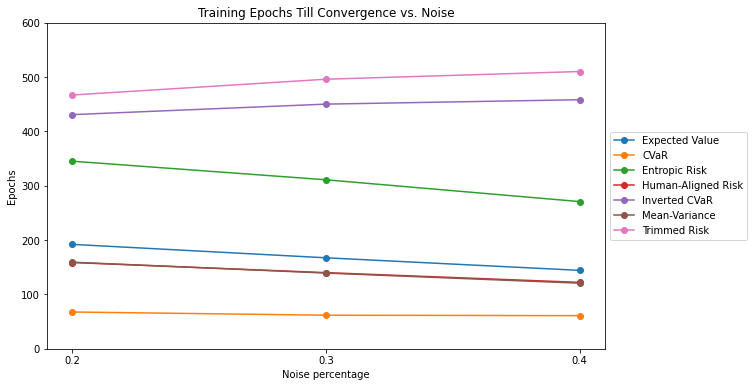

In [44]:
plt.figure(figsize=(10,6))

for objective in train_keys:
    objective_name = objective.split('_')[0]
    means = []
    for noise in noises:
        epochs = metrics[objective]['epochs_noise=' + str(noise)]
        means.append(np.mean(epochs))
        print('Objective: {}, Noise: {}, Mean: {}, Max: {}, Min: {}, Std Dev: {}'.format(objective_name, noise, np.mean(epochs), max(epochs), min(epochs), np.std(epochs)))
    plt.plot([0.2, 0.3, 0.4], means, marker='o', label=objective_name)

plt.xticks([0.2, 0.3, 0.4])
plt.yticks(np.arange(0, 601, 100))
plt.title('Training Epochs Till Convergence vs. Noise')
plt.xlabel('Noise percentage')
plt.ylabel('Epochs')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# CVaR Optimization Comparisons

In [14]:
def plot_loss_curve(losses, path, fname):
    plt.plot(losses)

    os.makedirs(path, exist_ok=True)
    plt.savefig(path + fname + '.png')
    
    plt.close()

# ERM

In [29]:
seeds = [i for i in range(10)]
noises = [0.2, 0.3, 0.4]

objectives = {
    'CVaR': cvar.CVaR(a=0.2), # We look at worst alpha% of losses
}

for objective in objectives.keys():
    losses = []
    test_cvars = []
    train_cvars = []
    cvars = []
    accs = []
    for noise in noises:
        for seed in seeds:
            X_train, X_test, y_train, y_test = generate_data(2000, 2000, noise, seed=seed)
            # Get objective
            criterion = objectives[objective]

            # Reset random seeds for comparaison.
            torch.manual_seed(seed)
            random.seed(seed)
            np.random.seed(seed)

            model = LogisticRegression(input_size, output_size)
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

            # Train
            model.train()
            
            losses = []
            convergence_losses = []
            converged = False
            while not converged:
                optimizer.zero_grad()

                output = model(X_train)
                loss = criterion(output, y_train.squeeze(1).type(torch.LongTensor))
                
                cvar_criterion = cvar.CVaR(a=0.2)
                train_output = model(X_train)
                convergence_losses.append(cvar_criterion(train_output, y_train.squeeze(1).type(torch.LongTensor)).item())
                losses.append(loss.item())
                
                # Let convergence criterion be if current loss is within the average of past 20 gradients by 1e-4
                if len(convergence_losses) > 20:
                    converged = abs(loss.item() - np.mean(convergence_losses[-20:])) <= 1e-4
                else:
                    converged = False
                
                loss.backward()
                optimizer.step()
                
            path = 'noisy_labels/cvar_loss_curves/' + objective + '/'
            fname = 'noise=' + str(noise) + '_seed=' + str(seed)
            plot_loss_curve(losses, path, fname)

            # Evaluate
            model.eval()

            loss_criterion = nn.CrossEntropyLoss()
            cvar_criterion = cvar.CVaR(a=0.2)

            with torch.no_grad():
                train_output = model(X_train)
                train_cvars.append(cvar_criterion(train_output, y_train.squeeze(1).type(torch.LongTensor)))
                
                test_output = model(X_test)
                test_cvars.append(cvar_criterion(test_output, y_test.squeeze(1).type(torch.LongTensor)))
                
        print('Objective: {}, Noise: {}, Average Train CVaR: {}, Average Test CVaR: {}'.format(objective, noise, np.mean(train_cvars), np.mean(test_cvars)))

Objective: CVaR, Noise: 0.2, Average Train CVaR: 0.7014983892440796, Average Test CVaR: 0.6957090497016907
Objective: CVaR, Noise: 0.3, Average Train CVaR: 0.6999002695083618, Average Test CVaR: 0.6951888203620911
Objective: CVaR, Noise: 0.4, Average Train CVaR: 0.6998044848442078, Average Test CVaR: 0.69573575258255


# Trunc-CVaR

In [30]:
seeds = [i for i in range(10)]
noises = [0.2, 0.3, 0.4]

objectives = {
    'Trunc-CVaR': nn.CrossEntropyLoss(reduction='none')
}

for objective in objectives.keys():
    losses = []
    test_cvars = []
    train_cvars = []
    cvars = []
    accs = []
    for noise in noises:
        for seed in seeds:
            X_train, X_test, y_train, y_test = generate_data(2000, 2000, noise, seed=seed)
            # Get objective
            criterion = objectives[objective]

            # Reset random seeds for comparaison.
            torch.manual_seed(seed)
            random.seed(seed)
            np.random.seed(seed)

            model = LogisticRegression(input_size, output_size)
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

            eta = 0
            eta_lr = 1e-2
            eta = Variable(torch.zeros(1), requires_grad=True)
            alpha = 0.2

            # Train
            model.train()
            
            losses = []
            convergence_losses = []
            converged = False
            while not converged:
                # clear the gradients so they wont accumulate
                optimizer.zero_grad()

                output = model(X_train)

                loss_eta = criterion(output, y_train.squeeze(1).type(torch.LongTensor)) - eta
                loss = (1 / alpha) * torch.mean(torch.relu(loss_eta)) + eta
                
                cvar_criterion = cvar.CVaR(a=0.2)
                train_output = model(X_train)
                losses.append(cvar_criterion(train_output, y_train.squeeze(1).type(torch.LongTensor)).item())
                convergence_losses.append(loss.item())

                # calculate gradient
                loss.backward(retain_graph=True)
                
                # Let convergence criterion be if current loss is within the average of past 20 gradients by 1e-4
                if len(convergence_losses) > 20:
                    converged = abs(loss.item() - np.mean(convergence_losses[-20:])) <= 1e-4
                else:
                    converged = False

                # gradient descent
                optimizer.step()

                # Update eta
                eta.data -= eta_lr * eta.grad.data

                # Clear variable gradients
                eta.grad.data.zero_()
                
            path = 'noisy_labels/cvar_loss_curves/' + objective + '/'
            fname = 'noise=' + str(noise) + '_seed=' + str(seed)
            plot_loss_curve(losses, path, fname)

            # Evaluate
            model.eval()

            loss_criterion = nn.CrossEntropyLoss()
            cvar_criterion = cvar.CVaR(a=0.2)

            with torch.no_grad():
                train_output = model(X_train)
                train_cvars.append(cvar_criterion(train_output, y_train.squeeze(1).type(torch.LongTensor)))
                
                test_output = model(X_test)
                test_cvars.append(cvar_criterion(test_output, y_test.squeeze(1).type(torch.LongTensor)))
                
        print('Objective: {}, Noise: {}, Average Train CVaR: {}, Average Test CVaR: {}'.format(objective, noise, np.mean(train_cvars), np.mean(test_cvars)))



Objective: Trunc-CVaR, Noise: 0.2, Average Train CVaR: 0.7047609686851501, Average Test CVaR: 0.698094367980957
Objective: Trunc-CVaR, Noise: 0.3, Average Train CVaR: 0.7053700685501099, Average Test CVaR: 0.6969765424728394
Objective: Trunc-CVaR, Noise: 0.4, Average Train CVaR: 0.7049921751022339, Average Test CVaR: 0.6958437561988831


# Adaptive Sampling

In [40]:
%reload_ext autoreload

In [10]:
from adacvar.util.cvar import CVaR, SoftCVaR as ada_CVaR, SoftCVaR
from adacvar.util.adaptive_algorithm import Exp3Sampler
from torch.utils.data import Dataset, DataLoader
from adacvar.util.learning_rate_decay import AdaGrad, Constant, RobbinsMonro

class NoisyLabelDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], idx
    
def get_adaptive_algorithm(is_adaptive, dataset, alpha, bsz, eta, gamma=0, beta=0, eps=0):
    num_points = len(dataset)
    
    if is_adaptive:
        iid_batch = False
    else:
        eta = 1e-3
        gamma = 0
        beta = 0
        eps = 1e-16
        iid_batch = True
        
    exp3 = Exp3Sampler(
            batch_size=bsz,
            num_actions=num_points,
            size=int(np.ceil(alpha * num_points)),
            eta=eta,
            gamma=gamma,
            beta=beta,
            eps=eps,
            iid_batch=iid_batch,
        )
    loader = DataLoader(dataset, batch_sampler=exp3)
    return loader, loader.batch_sampler

In [17]:
alpha = 0.2
# Try alpha = 1 or don't update weights/uniform weights
seeds = [i for i in range(10)]
noises = [0.3]

objectives = {
    'Adaptive Sampling': ada_CVaR(alpha=1, learning_rate=0),
#     'AdaVar Mean': CVaR(alpha=1, learning_rate=0),
#     'AdaVar Trunc CVaR': CVaR(alpha=alpha, learning_rate=1e-3),
#     'Soft CVaR': SoftCVaR(alpha=alpha, learning_rate=1e-3, temperature=1.0)
}

for objective in objectives.keys():
    losses = []
    test_cvars = []
    train_cvars = []
    accs = []
    for noise in noises:
        for seed in seeds:
            X_train, X_test, y_train, y_test = generate_data(2000, 2000, noise, seed=seed)
            # Get CVaR Objective
            cvar_train_obj = objectives[objective]
            criterion = nn.CrossEntropyLoss(reduction='none')

            # Reset random seeds for comparaison.
            torch.manual_seed(seed)
            random.seed(seed)
            np.random.seed(seed)

            model = LogisticRegression(input_size, output_size)
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

#             exp3_lr = np.sqrt(1 / alpha * np.log(1 / alpha))
            exp3_lr = 1e-2
            is_adaptive = objective == 'Adaptive Sampling'
            train_dataset = NoisyLabelDataset(X_train, y_train)
            train_loader, adaptive_algorithm = get_adaptive_algorithm(is_adaptive, train_dataset, alpha, len(X_train), exp3_lr)

            # Train
            model.train()
            
            losses = []
            convergence_losses = []
            converged = False
            while not converged:
                for batch_idx, (data, target, idx) in enumerate(train_loader):
                    # Sample data
                    data, target = data.to('cpu'), target.to('cpu')

                    # clear the gradients so they wont accumulate
                    optimizer.zero_grad()
                    cvar_train_obj.zero_grad()

                    output = model(data)

                    loss = criterion(output, target.squeeze(1).type(torch.LongTensor))
                        
                    # batch sampler (not cyclic sampler line 93 adacvar.util.train.py)
                    weights = 1.0
                    probabilities = adaptive_algorithm.probabilities

                    # Feedback loss to sampler.
                    adaptive_algorithm.update(
                        1 - np.clip(loss.cpu().detach().numpy(), 0, 1), idx, probabilities
                    )

                    # Calculate CVaR and Reduce to mean.
                    cvar_loss = (torch.tensor(weights).float().to('cpu') * cvar_train_obj(loss)).mean()
                    loss = loss.mean()
                    
                    cvar_criterion = cvar.CVaR(a=0.2)
                    train_output = model(X_train)
                    losses.append(cvar_criterion(train_output, y_train.squeeze(1).type(torch.LongTensor)).item())
                    convergence_losses.append(cvar_loss.item())

                    # Let convergence criterion be if current loss is within the average of past 20 gradients by 1e-4
                    if len(convergence_losses) > 20:
                        converged = abs(cvar_loss.item() - np.mean(convergence_losses[-20:])) <= 1e-4
                    else:
                        converged = False

                    # Compute Criterion and back-propagate.
                    cvar_loss.backward()

                    # gradient descent
                    optimizer.step()

    #                     print('Epoch: {}, Batch idx: {}, CVaR: {}, Loss: {}, VaR: {}'.format(epoch, batch_idx, cvar_loss, loss, cvar.var))

                    # Renormalize sampler
                    adaptive_algorithm.normalize()
            
            path = 'noisy_labels/cvar_loss_curves/' + objective + '/'
            fname = 'noise=' + str(noise) + '_seed=' + str(seed)
            plot_loss_curve(losses, path, fname)
        
            # Evaluate
            model.eval()

            cvar_criterion = cvar.CVaR(a=0.2)

            with torch.no_grad():
                train_output = model(X_train)
                train_cvars.append(cvar_criterion(train_output, y_train.squeeze(1).type(torch.LongTensor)))
                
                test_output = model(X_test)
                test_cvars.append(cvar_criterion(test_output, y_test.squeeze(1).type(torch.LongTensor)))
                
        print('Objective: {}, Noise: {}, Average Train CVaR: {}, Average Test CVaR: {}'.format(objective, noise, np.mean(train_cvars), np.mean(test_cvars)))

Objective: Adaptive Sampling, Noise: 0.3, Average Train CVaR: 0.8797289133071899, Average Test CVaR: 0.8083356022834778
